# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import requests

from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.metrics import accuracy_score
import math 

In [2]:
#ptc_data=pd.read_csv("D:\\FP2\\all commercial\\all commercial\\petroluem coke\\Total_consumption_petroleum_coke_West_North_Central_(total)_all_commercial_(total)_monthly.csv")
ptc_data=pd.read_csv("Total_consumption_petroleum_coke_West_North_Central_(total)_all_commercial_(total)_monthly.csv")
ptc_data=ptc_data.rename(columns={'Series ID: ELEC.CONS_TOT.PC-WNC-96.M thousand tons':'ptc_Con'})
mean_values = (ptc_data['ptc_Con'].shift() + ptc_data['ptc_Con'].shift(-1)) / 2

# Replace missing values with the mean of the preceding and following values
ptc_data['ptc_Con'].fillna(method='ffill', inplace=True)
ptc_data['D'] = ptc_data['Month'].str.slice(0, 2)
ptc_data['M'] = ptc_data['Month'].str.slice(3, 5)
ptc_data['Y'] = ptc_data['Month'].str.slice(6, 10)
ptc_data['Date1'] = ptc_data['Y']+'-'+ptc_data['M']+'-'+ptc_data['D']
ptc_data['Date'] = pd.to_datetime(ptc_data['Date1'])
ptc_data3=ptc_data.sort_values(['Date'],ascending=True)
ptc_data4=ptc_data3[['Date','ptc_Con']]
ptc_data4

,Date,ptc_Con
0,2001-01-01,0.590
1,2001-02-01,0.550
2,2001-03-01,0.540
3,2001-04-01,0.460
4,2001-05-01,0.520
...,...,...
256,2022-05-01,2.225
257,2022-06-01,1.943
258,2022-07-01,1.380
259,2022-08-01,0.000


In [3]:
#libaries for time series
from statsmodels.tools.eval_measures import rmse
import seaborn as sns
import statsmodels.api as sm
import itertools
from statsmodels.tsa.arima_model import ARIMA, ARMA
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing 

<AxesSubplot:xlabel='Date'>

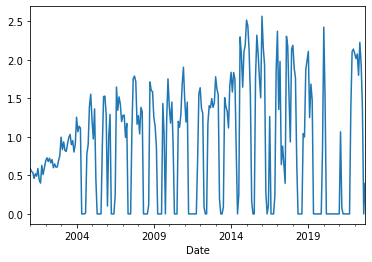

In [4]:
# dataset creation
#coal_data4=coal_data3.copy()
df = ptc_data4.set_index("Date")
df['ptc_Con'].plot(style="-")

In [5]:
y=df['ptc_Con']
y_to_val = y['2018-12-01':] # dataset to train
y_to_train = y[:'2018-12-01'] # last X months for test  
#predict_date = len(y) - len(y[:'Q4 2017']-1) 
train=pd.DataFrame(y_to_train)
test=pd.DataFrame(y_to_val)


# Seasonal Naive Forecast model

In [6]:
def pysnaive(train_series,seasonal_periods,forecast_horizon):
    '''
    Python implementation of Seasonal Naive Forecast. 
    This should work similar to https://otexts.com/fpp2/simple-methods.html
    Returns two arrays
     > fitted: Values fitted to the training dataset
     > fcast: seasonal naive forecast
    
    Author: Sandeep Pawar
    
    Date: Apr 9, 2020
    
    Ver: 1.0
    
    train_series: Pandas Series
        Training Series to be used for forecasting. This should be a valid Pandas Series. 
        Length of the Training set should be greater than or equal to number of seasonal periods
        
    Seasonal_periods: int
        No of seasonal periods
        Yearly=1
        Quarterly=4
        Monthly=12
        Weekly=52
        

    Forecast_horizon: int
        Number of values to forecast into the future
    
    e.g. 
    fitted_values = pysnaive(train,12,12)[0]
    fcast_values = pysnaive(train,12,12)[1]
    '''
    
    if len(train_series)>= seasonal_periods: #checking if there are enough observations in the training data
        
        last_season=train_series.iloc[-seasonal_periods:]
        
        reps=np.int(np.ceil(forecast_horizon/seasonal_periods))
        
        fcarray=np.tile(last_season,reps)
        
        fcast=pd.Series(fcarray[:forecast_horizon])
        
        fitted = train_series.shift(seasonal_periods)
        
    else:
        fcast=print("Length of the trainining set must be greater than number of seasonal periods") 
    
    return fitted, fcast

In [7]:
import mlflow
import pandas as pd
import pmdarima as pm
# from fbprophet import Prophet
from prophet import Prophet
import matplotlib.pyplot as plt

# Set up mlflow tracking
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("forecasting-model-petroluem-coke")
mlflow.tensorflow.autolog()

2023-02-25 22:57:36.863632: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023/02/25 22:57:40 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Cmd('git') failed due to: exit code(1)
  cmdline: git version
  stderr: 'xcrun: error: invalid active developer path (/Library/Developer/CommandLineTools), missing xcrun at: /Library/Developer/CommandLineTools/usr/bin/xcrun'


Mean Absolute error is 0.5250972222222222
MAPE is inf
RMSE is 0.7148324039526612


2023/02/25 22:57:40 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


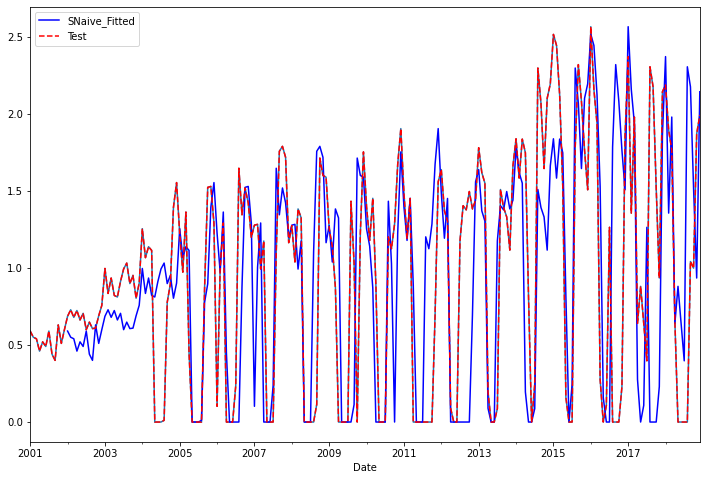

In [8]:
with mlflow.start_run():
    #Fitted values
    py_snaive_fit = pysnaive(train["ptc_Con"], 
                         seasonal_periods=12,
                         forecast_horizon=len(train))[0]

    #forecast
    py_snaive = pysnaive(train["ptc_Con"], 
                         seasonal_periods=12,
                         forecast_horizon=len(train))[1]

    #Residuals
    py_snaive_resid = (train["ptc_Con"] - py_snaive_fit).dropna()



    predictions=train.copy()
    predictions["py_snaive"] = py_snaive.values 


    predictions

    # Charting the output
    pd.plotting.register_matplotlib_converters()
    fig = plt.figure(figsize=(10,5))
    train["ptc_Con"].plot(figsize=(12,8))#, style="--", color="gray", legend=True, label="Train")
    py_snaive_fit.plot(color="b", legend=True, label="SNaive_Fitted")
    predictions["ptc_Con"].plot(style="--",color="r", legend=True, label="Test")
    #predictions["py_snaive"].plot(color="b", legend=True, label="Snaive_fc");


    #MAE
    n=mean_absolute_error(predictions["ptc_Con"], predictions["py_snaive"])
    print("Mean Absolute error is",n)

    #MAPE
    k=np.mean(np.abs((predictions["ptc_Con"] - predictions["py_snaive"]) / predictions["ptc_Con"])) * 100
    print("MAPE is",k)

    #RMSE
    r=math.sqrt(mean_squared_error(predictions["ptc_Con"], predictions["py_snaive"]))
    print("RMSE is",r)

    # Log model parameters and metrics to mlflow
    mlflow.log_param("model", "py_snaive")
    #mlflow.set_tag("model", py_snaive_fit)
    mlflow.log_metric("mae", n)
    mlflow.log_metric("mape", k)
    mlflow.log_metric("rmse", r)
    mlflow.log_figure(fig, "Seasonal-Naive.png")
    
    
    # Save model as artifact
    mlflow.sklearn.log_model(py_snaive_fit, "model")

In [9]:
if (train["ptc_Con"] <= 0).any().any():
    # replace negative and zero values with positive values
    train["ptc_Con"] = train["ptc_Con"].apply(lambda x: abs(x) + 0.01 if x <= 0 else x)
print(train)

            ptc_Con
Date               
2001-01-01    0.590
2001-02-01    0.550
2001-03-01    0.540
2001-04-01    0.460
2001-05-01    0.520
...             ...
2018-08-01    0.010
2018-09-01    1.041
2018-10-01    0.998
2018-11-01    1.869
2018-12-01    1.991

[216 rows x 1 columns]


# Holt-Winter's Method

Mean Absolute error is 1.1137950919399917
MAPE is inf
RMSE is 1.31723500405046


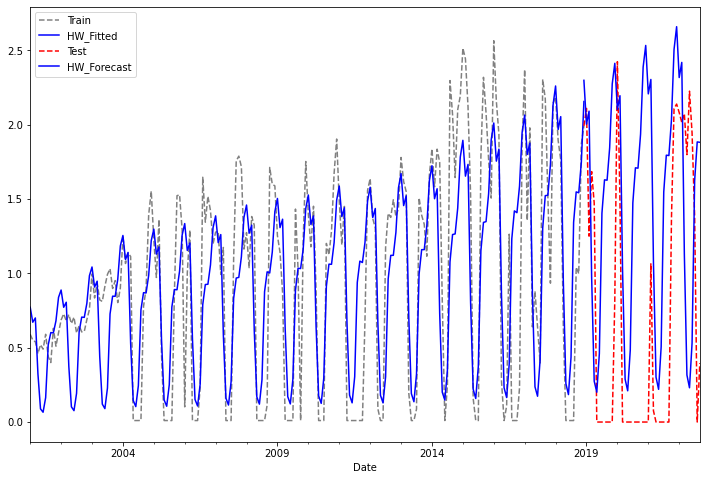

In [10]:
with mlflow.start_run():

    hw_model = ExponentialSmoothing(train["ptc_Con"],
                              trend    ="mul",
                              seasonal = "mul", 
                              seasonal_periods=12).fit()

    hw_fitted = hw_model.fittedvalues

    hw_resid = hw_model.resid

    #Adding the mean of the residuals to correct the bias.
    py_hw = hw_model.forecast(len(test["ptc_Con"]))+np.mean(hw_resid)
    py_hw=pd.DataFrame(py_hw)
    py_hw.columns=['py_hw']
    py_hw=py_hw.reset_index()
    py_hw=py_hw.drop('index',axis=1)
    predictions1=test.copy()
    predictions1=predictions1.reset_index()
    py_hw2 = pd.concat([predictions1,py_hw],axis=1)
    py_hw2=py_hw2.set_index('Date')
    py_hw2

    fig = plt.figure(figsize=(10,5))
    train["ptc_Con"].plot(figsize=(12,8), style="--", color="gray", legend=True, label="Train")
    hw_fitted.plot(color="b", legend=True, label="HW_Fitted")
    py_hw2["ptc_Con"].plot(style="--",color="r", legend=True, label="Test")
    py_hw2["py_hw"].plot(color="b", legend=True, label="HW_Forecast")

    #MAE
    n=mean_absolute_error(py_hw2.ptc_Con, py_hw2["py_hw"])
    print("Mean Absolute error is",n)

    #MAPE
    k=np.mean(np.abs((py_hw2.ptc_Con - py_hw2["py_hw"]) / py_hw2.ptc_Con)) * 100
    print("MAPE is",k)

    #RMSE
    r=math.sqrt(mean_squared_error(py_hw2.ptc_Con, py_hw2["py_hw"]))
    print("RMSE is",r)
    mlflow.log_param("model", "Holt-Winter")
    mlflow.log_metric("mae", n)
    mlflow.log_metric("mape", k)
    mlflow.log_metric("rmse", r)
    mlflow.log_figure(fig, "Holt-winter.png")
    # Save model as artifact
    mlflow.sklearn.log_model(hw_model, "model")

# ETS Model

In [11]:
#ptc_data=pd.read_csv("D:\\FP2\\all commercial\\all commercial\\petroluem coke\\Total_consumption_petroleum_coke_West_North_Central_(total)_all_commercial_(total)_monthly.csv")
ptc_data=pd.read_csv("Total_consumption_petroleum_coke_West_North_Central_(total)_all_commercial_(total)_monthly.csv")
ptc_data=ptc_data.rename(columns={'Series ID: ELEC.CONS_TOT.PC-WNC-96.M thousand tons':'ptc_Con'})
mean_values = (ptc_data['ptc_Con'].shift() + ptc_data['ptc_Con'].shift(-1)) / 2

# Replace missing values with the mean of the preceding and following values
ptc_data['ptc_Con'].fillna(method='ffill', inplace=True)
ptc_data['D'] = ptc_data['Month'].str.slice(0, 2)
ptc_data['M'] = ptc_data['Month'].str.slice(3, 5)
ptc_data['Y'] = ptc_data['Month'].str.slice(6, 10)
ptc_data['Date1'] = ptc_data['Y']+'-'+ptc_data['M']+'-'+ptc_data['D']
ptc_data['Date'] = pd.to_datetime(ptc_data['Date1'])
ptc_data3=ptc_data.sort_values(['Date'],ascending=True)
ptc_data4=ptc_data3[['Month','ptc_Con']]
df = ptc_data4.set_index("Month")
y=df['ptc_Con']
y_to_val = y['01-12-2018':] # dataset to train
y_to_train = y[:'01-12-2018'] # last X months for test  
#predict_date = len(y) - len(y[:'Q4 2017']-1) 
train=pd.DataFrame(y_to_train)
test=pd.DataFrame(y_to_val)


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.64037D-01    |proj g|=  3.66788D-02

At iterate    5    f=  6.89464D-01    |proj g|=  5.80267D-04

At iterate   10    f=  6.88406D-01    |proj g|=  3.09988D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     20      1     0     0   4.776D-06   6.864D-01
  F =  0.68643148714758151     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Mean Absolute error is 0.9893599161453628
MAPE is inf
RMSE is 1.133057

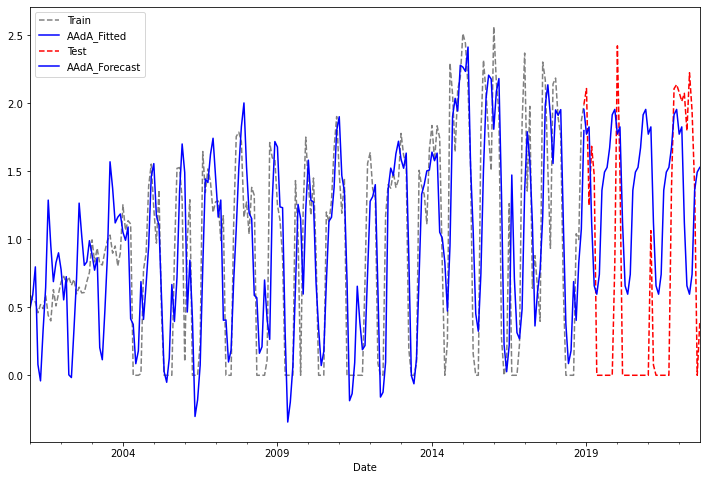

In [12]:
with mlflow.start_run():

    ets_AAdA=sm.tsa.statespace.ExponentialSmoothing(train["ptc_Con"],
                                               trend=True, 
                                               initialization_method= 'concentrated', 
                                               seasonal=12, 
                                               damped_trend=True).fit()

    fc_AAdA=ets_AAdA.forecast(len(test))

    fc_AAdA=pd.DataFrame(fc_AAdA)
    fc_AAdA.columns=['fc_AAdA']
    fc_AAdA=fc_AAdA.reset_index()
    fc_AAdA=fc_AAdA.drop('index',axis=1)
    predictions2=test.copy()
    predictions2=predictions2.reset_index()
    fc_AAdA2 = pd.concat([predictions2,fc_AAdA],axis=1)
    fc_AAdA2=fc_AAdA2.set_index('Month')
    fc_AAdA2=fc_AAdA2.reset_index()
    fc_AAdA2['D'] = fc_AAdA2['Month'].str.slice(0, 2)
    fc_AAdA2['M'] = fc_AAdA2['Month'].str.slice(3, 5)
    fc_AAdA2['Y'] = fc_AAdA2['Month'].str.slice(6, 10)
    fc_AAdA2['Date1'] = fc_AAdA2['Y']+'-'+fc_AAdA2['M']+'-'+fc_AAdA2['D']
    fc_AAdA2['Date'] = pd.to_datetime(fc_AAdA2['Date1'])
    fc_AAdA2=fc_AAdA2[['Date','ptc_Con','fc_AAdA']]
    fc_AAdA2=fc_AAdA2.set_index('Date')
    fc_AAdA2

    ets_AAdA2=pd.DataFrame(ets_AAdA.fittedvalues)
    ets_AAdA2=ets_AAdA2.reset_index()
    ets_AAdA2['D'] = ets_AAdA2['Month'].str.slice(0, 2)
    ets_AAdA2['M'] = ets_AAdA2['Month'].str.slice(3, 5)
    ets_AAdA2['Y'] = ets_AAdA2['Month'].str.slice(6, 10)
    ets_AAdA2['Date1'] = ets_AAdA2['Y']+'-'+ets_AAdA2['M']+'-'+ets_AAdA2['D']
    ets_AAdA2['Date'] = pd.to_datetime(ets_AAdA2['Date1'])
    ets_AAdA2=ets_AAdA2[['Date',0]]
    ets_AAdA2=ets_AAdA2.set_index('Date')
    ets_AAdA2

    train2=train.reset_index()
    train2['D'] = train2['Month'].str.slice(0, 2)
    train2['M'] = train2['Month'].str.slice(3, 5)
    train2['Y'] = train2['Month'].str.slice(6, 10)
    train2['Date1'] = train2['Y']+'-'+train2['M']+'-'+train2['D']
    train2['Date'] = pd.to_datetime(train2['Date1'])
    train2=train2[['Date','ptc_Con']]
    train2=train2.set_index('Date')
    train2

    #Plotting
    fig = plt.figure(figsize=(10,5))
    train2["ptc_Con"].plot(figsize=(12,8), style="--", color="gray", legend=True, label="Train")
    ets_AAdA2[0].plot(color="b", legend=True, label="AAdA_Fitted")
    fc_AAdA2["ptc_Con"].plot(style="--",color="r", legend=True, label="Test")
    fc_AAdA2["fc_AAdA"].plot(color="b", legend=True, label="AAdA_Forecast")

    #MAE
    n=mean_absolute_error(fc_AAdA2.ptc_Con, fc_AAdA2["fc_AAdA"])
    print("Mean Absolute error is",n)

    #MAPE
    k=np.mean(np.abs((fc_AAdA2.ptc_Con - fc_AAdA2["fc_AAdA"]) / fc_AAdA2.ptc_Con)) * 100
    print("MAPE is",k)

    #RMSE
    r=math.sqrt(mean_squared_error(fc_AAdA2.ptc_Con, fc_AAdA2["fc_AAdA"]))
    print("RMSE is",r)

    mlflow.log_param("model", "ETS")
    mlflow.log_metric("mae", n)
    mlflow.log_metric("mape", k)
    mlflow.log_metric("rmse", r)
    mlflow.log_figure(fig, "ETS.png")
    # Save model as artifact
    mlflow.sklearn.log_model(ets_AAdA, "model")

# SARIMA

In [13]:
#ptc_data=pd.read_csv("D:\\FP2\\all commercial\\all commercial\\petroluem coke\\Total_consumption_petroleum_coke_West_North_Central_(total)_all_commercial_(total)_monthly.csv")
ptc_data=pd.read_csv("Total_consumption_petroleum_coke_West_North_Central_(total)_all_commercial_(total)_monthly.csv")
ptc_data=ptc_data.rename(columns={'Series ID: ELEC.CONS_TOT.PC-WNC-96.M thousand tons':'ptc_Con'})
mean_values = (ptc_data['ptc_Con'].shift() + ptc_data['ptc_Con'].shift(-1)) / 2

# Replace missing values with the mean of the preceding and following values
ptc_data['ptc_Con'].fillna(method='ffill', inplace=True)
ptc_data['D'] = ptc_data['Month'].str.slice(0, 2)
ptc_data['M'] = ptc_data['Month'].str.slice(3, 5)
ptc_data['Y'] = ptc_data['Month'].str.slice(6, 10)
ptc_data['Date1'] = ptc_data['Y']+'-'+ptc_data['M']+'-'+ptc_data['D']
ptc_data['Date'] = pd.to_datetime(ptc_data['Date1'])
ptc_data3=ptc_data.sort_values(['Date'],ascending=True)
ptc_data4=ptc_data3[['Date','ptc_Con']]
df = ptc_data4.set_index("Date")
y=df['ptc_Con']
y_to_val = y['2018-12-01':] # dataset to train
y_to_train = y[:'2018-12-01'] # last X months for test  
#predict_date = len(y) - len(y[:'Q4 2017']-1) 
train=pd.DataFrame(y_to_train)
test=pd.DataFrame(y_to_val)


In [14]:
# determining the parameters
import itertools

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
               
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

sarima_grid_search(y,12)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57789D+00    |proj g|=  2.42958D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   4.948D-06   1.578D+00
  F =   1.5778851959113891     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.4

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.36808D-01    |proj g|=  2.63237D-01

At iterate    5    f=  9.16860D-01    |proj g|=  1.81660D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     10      1     0     0   8.605D-07   9.169D-01
  F =  0.91685956308907790     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  9.52890D-01    |proj g|=  4.42253D-02

At iterate   10    f=  9.51363D-01    |proj g|=  1.67817D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     13      1     0     0   6.062D-06   9.514D-01
  F =  0.95136257778635525     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00233D+00    |proj g|=  1.70544D-05

           * * *

Tit   = total number of iterations
Tnf   = total num

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.52548D-01    |proj g|=  1.67322D-01

At iterate    5    f=  9.20302D-01    |proj g|=  1.11078D-01

At iterate   10    f=  9.17876D-01    |proj g|=  1.11064D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     14      1     0     0   1.677D-07   9.179D-01
  F =  0.91787624196202000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.41845D+00    |proj g|=  4.93668D+00

At iterate    5    f=  1.17118D+00    |proj g|=  1.07985D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     13      1     0     0   2.065D-07   1.171D+00
  F =   1.1711636593716814     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     13      1     0     0   4.208D-06   1.015D+00
  F =   1.0153755569274534     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.65567D-01    |proj g|=  1.57540D-01

At iterate    5    f=  9.58506D-01    |proj g|=  1.65595D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.73085D-01    |proj g|=  8.88197D-02

At iterate   10    f=  7.66717D-01    |proj g|=  4.61485D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     18      1     0     0   6.010D-05   7.667D-01
  F =  0.76667657188838068     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.59340D-01    |proj g|=  2.61203D-01

At iterate    5    f=  8.45196D-01    |proj g|=  4.81499D-05

       

 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.12500D-01    |proj g|=  3.81135D-01

At iterate    5    f=  7.46392D-01    |proj g|=  1.15941D-01

At iterate   10    f=  7.42691D-01    |proj g|=  1.46259D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   1.463D-05   7.427D-01
  F =  0.74269134842200668     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.93335D-01    |proj g|=  1.28642D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      6      1     0     0   3.081D-05   8.933D-01
  F =  0.89332027743584352     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.5

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     18      1     0     0   1.956D-05   7.960D-01
  F =  0.79603079317375802     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.38737D-01    |proj g|=  2.77695D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  8.11217D-01    |proj g|=  1.82434D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     23      1     0     0   1.756D-05   8.111D-01
  F =  0.81114189515372426     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.06882D-01    |proj g|=  2.29594D-05


 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     21      1     0     0   2.296D-05   9.069D-01
  F =  0.90688171803093076     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.43370D-01    |proj g|=  2.25542D-01


 This problem is unconstrained.



At iterate    5    f=  8.03874D-01    |proj g|=  4.28484D-02
  ys=-1.920E-02  -gs= 2.855E-04 BFGS update SKIPPED

At iterate   10    f=  7.96031D-01    |proj g|=  5.22308D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     34      1     1     0   5.224D-04   7.960D-01
  F =  0.79603094869219848     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.91534D-01    |proj g|=  1.60986D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      7      1     0     0   3.433D-06   8.913D-01
  F =  0.89133670159179523     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.4

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.40003D-01    |proj g|=  6.94583D-02

At iterate    5    f=  8.35213D-01    |proj g|=  4.59383D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     10      1     0     0   8.291D-06   8.352D-01
  F =  0.83521325737498442     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     11      1     0     0   1.258D-06   8.650D-01
  F =  0.86497961796652134     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.26944D-01    |proj g|=  3.75709D-01

At iterate    5    f=  7.79507D-01    |proj g|=  3.56435D-02

At iterate   10    f=  7.79124D-01    |proj g|=  1.31679D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.62088D-01    |proj g|=  3.01380D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     17      1     0     0   3.013D-05   8.621D-01
  F =  0.86208849318589775     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.2

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.45616D-01    |proj g|=  4.39485D-01

At iterate    5    f=  7.01781D-01    |proj g|=  3.03879D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     11      1     0     0   8.239D-07   7.018D-01
  F =  0.70177332382341162     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.24326D-01    |proj g|=  2.74365D-02

At iterate   10    f=  7.23406D-01    |proj g|=  3.18955D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     15      1     0     0   2.703D-06   7.234D-01
  F =  0.72340638242103594     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.10531D-01    |proj g|=  2.22667D-01


 This problem is unconstrained.



At iterate    5    f=  8.03963D-01    |proj g|=  1.27310D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   3.664D-05   8.040D-01
  F =  0.80396257249722847     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.66196D-01    |proj g|=  3.71529D-01


 This problem is unconstrained.



At iterate    5    f=  7.11513D-01    |proj g|=  2.52489D-02
  ys=-3.280E-02  -gs= 1.186E-03 BFGS update SKIPPED

At iterate   10    f=  7.02304D-01    |proj g|=  2.57219D-02

At iterate   15    f=  7.01774D-01    |proj g|=  9.32509D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     39      1     1     0   9.325D-06   7.018D-01
  F =  0.70177354370441702     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.55525D-01    |proj g|=  1.31718D-02

At iterate    5    f=  8.55496D-01    |proj g|=  1.25398D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   1.798D-06   8.555D-01
  F =  0.85549608879458172     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.44563D-01    |proj g|=  4.42973D-01

At iterate    5    f=  6.97722D-01    |proj g|=  8.36607D-03

At iterate   10    f=  6.97386D-01    |proj g|=  9.14124D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     15      1     0     0   4.020D-06   6.974D-01
  F =  0.69738521002665810     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.73216D-01    |proj g|=  2.82047D-01

At iterate    5    f=  7.22673D-01    |proj g|=  2.73133D-02

At iterate   10    f=  7.20501D-01    |proj g|=  5.86198D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     16      1     0     0   8.061D-06   7.205D-01
  F =  0.72049763404328193     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate   10    f=  8.03924D-01    |proj g|=  1.46226D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     15      1     0     0   1.485D-05   8.039D-01
  F =  0.80392428117497272     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.65366D-01    |proj g|=  3.73806D-01


 This problem is unconstrained.



At iterate    5    f=  7.08921D-01    |proj g|=  1.02245D-01

At iterate   10    f=  6.97661D-01    |proj g|=  2.56047D-01

At iterate   15    f=  6.97386D-01    |proj g|=  1.13354D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     31      1     0     0   1.915D-03   6.974D-01
  F =  0.69738541491217210     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.92993D-01    |proj g|=  2.80212D-05

       

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.88702D-01    |proj g|=  1.23695D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   6.589D-07   7.887D-01
  F =  0.78870230866434132     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.39228D-01    |proj g|=  8.03048D-02

At iterate    5    f=  8.35237D-01    |proj g|=  1.00840D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.11702D-01    |proj g|=  8.03400D-02

At iterate   10    f=  8.03512D-01    |proj g|=  9.98684D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     33      1     0     0   1.267D-05   8.035D-01
  F =  0.80351139730793564     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.94547D-01    |proj g|=  2.17490D-01

At iterate    5    f=  8.86926D-01    |proj g|=  2.05589D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  7.65321D-01    |proj g|=  6.48817D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     18      1     0     0   4.539D-07   7.653D-01
  F =  0.76532062803777900     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.56545D-01    |proj g|=  3.31502D-01

At iterate    5    f=  9.33059D-01    |proj g|=  1.67915D-01


 This problem is unconstrained.



At iterate   10    f=  9.31204D-01    |proj g|=  1.01753D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     23      1     0     0   1.015D-04   9.312D-01
  F =  0.93120432961965438     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.80661D-01    |proj g|=  5.18981D-01


 This problem is unconstrained.



At iterate    5    f=  7.10419D-01    |proj g|=  2.47529D-02

At iterate   10    f=  7.09689D-01    |proj g|=  1.85632D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     16      1     0     0   1.208D-05   7.097D-01
  F =  0.70968768768763901     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.41451D-01    |proj g|=  2.35491D-01

At iterate    5    f=  7.59313D-01    |proj g|=  1.68202D-01

At iterate   10    f=  7.54888D-01    |proj g|=  2.79044D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     16      1     0     0   4.529D-06   7.549D-01
  F =  0.75488733830845789     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate   10    f=  7.31144D-01    |proj g|=  9.05408D-02

At iterate   15    f=  7.23446D-01    |proj g|=  4.23804D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     22      1     0     0   3.186D-06   7.234D-01
  F =  0.72344351201965340     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.46769D-01    |proj g|=  3.82624D-01


 This problem is unconstrained.



At iterate    5    f=  8.14747D-01    |proj g|=  4.03668D-02

At iterate   10    f=  8.10568D-01    |proj g|=  1.93512D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     33      1     0     0   3.375D-05   8.106D-01
  F =  0.81056556768141819     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.99008D-01    |proj g|=  4.67824D-01


 This problem is unconstrained.



At iterate    5    f=  7.25493D-01    |proj g|=  4.89883D-02

At iterate   10    f=  7.17534D-01    |proj g|=  2.62947D-02
  ys=-4.649E-02  -gs= 2.054E-04 BFGS update SKIPPED

At iterate   15    f=  7.09720D-01    |proj g|=  2.92839D-01

At iterate   20    f=  7.09689D-01    |proj g|=  5.26912D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     60      1     1     0   5.644D-03   7.097D-01
  F =  0.70968829542633838     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The set of parameters with the minimum AIC is: SARIMA(1, 0, 1)x(0, 1, 1, 12) - AIC:372.03507963391553


In [15]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    k=mean_absolute_error(y_forecasted, y_to_test)
    n=np.mean(np.abs((y_to_test - y_forecasted) / y_to_test)) * 100
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print("Mean Absolute error :",k)
    print("MAPE is :",n)
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    k_dynamic=mean_absolute_error(y_forecasted_dynamic, y_to_test)
    n_dynamic=np.mean(np.abs((y_to_test - y_forecasted_dynamic) / y_to_test)) * 100
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    r = round(np.sqrt(mse_dynamic), 2)
    print("Mean Absolute error :",k_dynamic)
    print("MAPE is :",n_dynamic)
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))
    fig = plt.figure(figsize=(10,5))
    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    with mlflow.start_run():
        #log the params
        mlflow.log_param("model", "SARIMA")
        #log the metrics
        mlflow.log_metric("mae", k_dynamic)
        mlflow.log_metric("mape", n_dynamic)
        mlflow.log_metric("rmse", r)
        #log the plot
        mlflow.log_figure(fig, "SARIMA.png")
        # Save model as artifact
        mlflow.pmdarima.log_model(results, "model")    
    
    return (results)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.44563D-01    |proj g|=  4.42973D-01


 This problem is unconstrained.



At iterate    5    f=  6.97722D-01    |proj g|=  8.36607D-03

At iterate   10    f=  6.97386D-01    |proj g|=  9.14124D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     15      1     0     0   4.020D-06   6.974D-01
  F =  0.69738521002665810     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5233      0.085      6.162      0.000       0.357       0.690
ma.L1          0.1534      0.102      1.507      0.132      -0

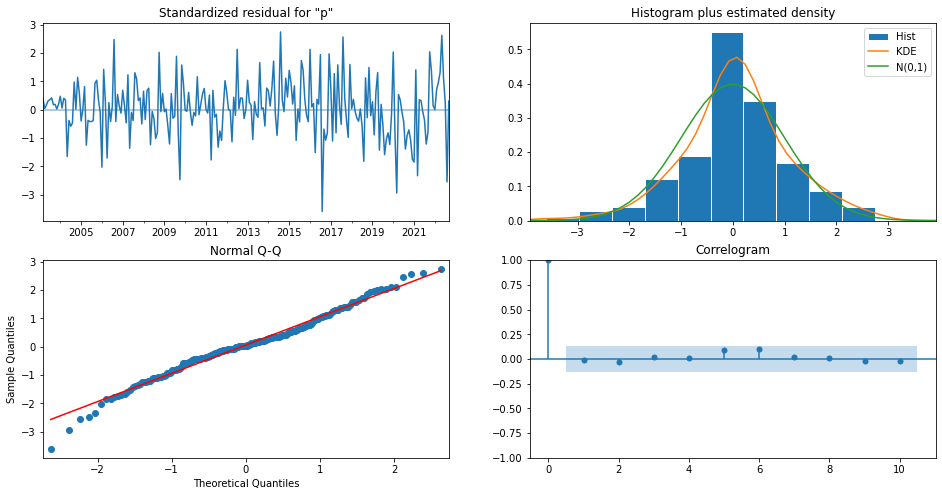

Mean Absolute error : 0.5075674283145176
MAPE is : inf
The Root Mean Squared Error of SARIMA with season_length=12 and dynamic = False 0.63


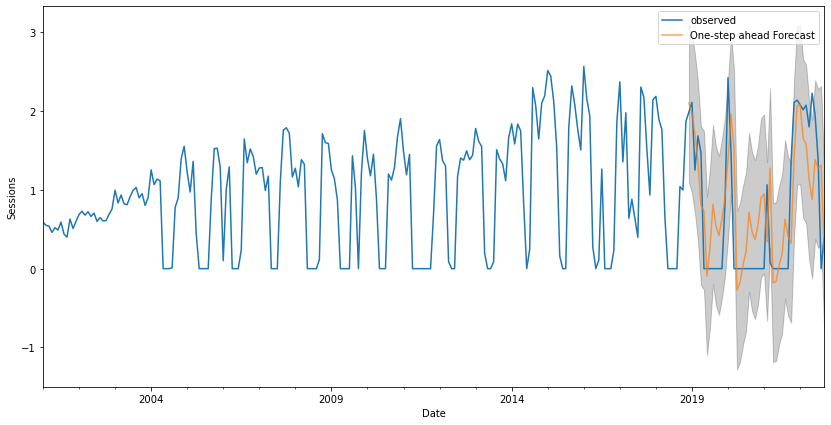

Mean Absolute error : 0.7724521337421394
MAPE is : inf
The Root Mean Squared Error of SARIMA with season_length=12 and dynamic = True 0.94


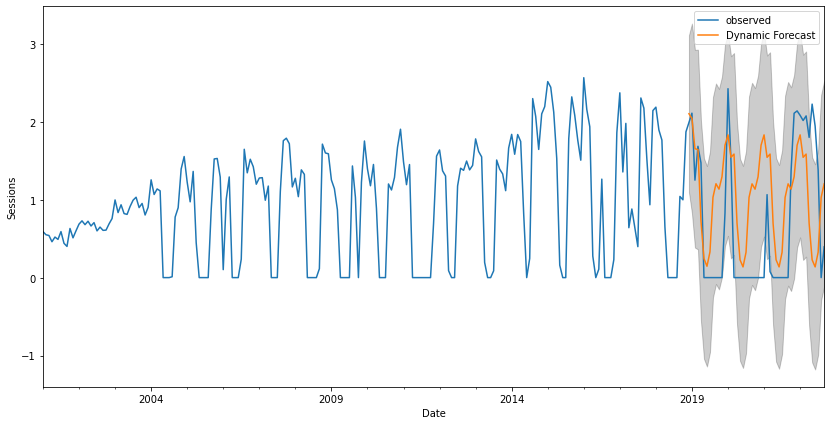

In [16]:
model = sarima_eva(y,(1, 0, 1),(0, 1, 1, 12),12,'2018-12-01',y_to_val)

In [17]:
# price forecasting
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)
    pred_ci = pred_uc.conf_int()
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    
    
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    
    pci2=pci.set_index('Date')
    pm2=pm.set_index('Date')
    ax = y.plot(label='observed', figsize=(14, 7))
    pm2.plot(ax=ax, label='Forecast')
    ax.fill_between(pci2.index,
                    pci2.iloc[:, 0],
                    pci2.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()

    final_table = pm.join(pci.set_index('Date'), on='Date')
    final_table=final_table.set_index('Date')
    return (final_table)

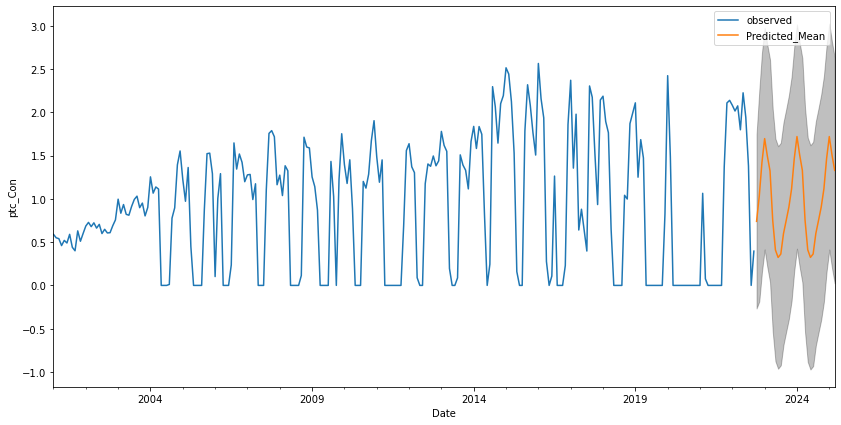

In [18]:
forecast_table=forecast(model,30,y)

In [19]:
forecast_table.to_csv('forecast_petroluemcoke_values.csv')